In [1]:
import numpy as np
from scipy.stats import norm
import pylab

In [2]:
# Кумулятивная функция стандартного нормального распределения
def N(x):
    return norm.cdf(x)


# Реальное значение V(S, t)
def V_S_t(S, t, E, r, sigma, T, option='Call'):
    d1 = (np.log(S / E) + (r + (1 / 2) * sigma**2) *
          (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)

    if option == 'Call':
        return S * N(d1) - E * np.exp(-r * (T - t)) * N(d2)
    elif option == 'Put':
        return E * np.exp(-r * (T - t)) * N(-d2) - S * N(-d1)


# Координаты
def S_i(i, h):
    return i * h


def t_j(j, tau):
    return j * tau

In [3]:
# Представление числа в экспоненциальной форме
def exp_form(a):
    return '%e' % a


# Округление числа a до n-го знака
def discard(a, n):
    return ('{0:.' + str(n) + 'f}').format(a).rstrip('0').rstrip('.')


# Отображение сетки в таблице
def print_grid(V):
    m, n = V.shape
    grid = pd.DataFrame([], columns=[i for i in range(n)])
    grid.columns.name = 'j (t) ↓ \ i (S) →'

    for j in range(m):
        grid.loc[j] = [0] * n

        for i in range(n):
            grid.loc[j, i] = discard(V[j][i], 3)

    display(grid)


# Решение 3-хдиагональной СЛАУ методом прогонки
def tridiagonal_matrix_algorithm(a, b, c, d):
    n = len(a)

    if a[0] != 0:
        raise Exception('Ошибка: a[0] должно быть = 0!')

    if c[n - 1] != 0:
        raise Exception('Ошибка: c[n - 1] должно быть = 0!')

    alpha = np.zeros((n))
    beta = np.zeros((n))
    x = np.zeros((n))

    for i in range(1, n):
        alpha[i] = -c[i - 1] / (a[i - 1] * alpha[i - 1] + b[i - 1])
        beta[i] = (d[i - 1] - a[i - 1] * beta[i - 1]) / (
            a[i - 1] * alpha[i - 1] + b[i - 1])

    x[n - 1] = (d[n - 1] - a[n - 1] * beta[n - 1]) / (a[n - 1] * alpha[n - 1] +
                                                      b[n - 1])

    for i in range(n - 2, -1, -1):
        x[i] = alpha[i + 1] * x[i + 1] + beta[i + 1]

    return x


# Инициализация определённых узлов сетки НУ и ГУ условиями
def init_V(m, n, E, h, option='Call'):
    V = np.empty((m, n))

    # Конечное условие
    for i in range(n):
        if option == 'Call':
            V[-1][i] = max(S_i(i, h) - E, 0)
        elif option == 'Put':
            V[-1][i] = max(E - S_i(i, h), 0)

    # Граничные условия
    for j in range(m):
        if option == 'Call':
            V[j][0] = 0
            V[j][-1] = S_i(n - 1, h)
        elif option == 'Put':
            V[j][0] = E
            V[j][-1] = 0

    return V


# Весовая схема
def weighting_difference_scheme(S_max,
                                T,
                                E,
                                r,
                                sigma,
                                tau,
                                h,
                                alpha=1 / 2,
                                option='Call'):
    # Коэффициенты
    def a_i(i):
        return (sigma**2 * i**2 - r * i) / 2

    def b_i(i):
        return -(sigma**2 * i**2 + r) + 1 / ((alpha - 1) * tau)

    def c_i(i):
        return (sigma**2 * i**2 + r * i) / 2

    # Значение правой части уравнения, приведённого к виду, удобному для использования метода прогонки
    def right_side(j, i):
        return V[j + 1][i - 1] * (
            alpha / (alpha - 1)) * a_i(i) + V[j + 1][i] * (
                (alpha / (alpha - 1)) * b_i(i) - alpha / (tau *
                                                          (alpha - 1)**2) + 1 /
                ((alpha - 1) * tau)) + V[j + 1][i + 1] * (alpha /
                                                          (alpha - 1)) * c_i(i)

    if not (1 / 2 <= alpha < 1):
        raise Exception(
            'Не выполняется условие устойчивости весовой схемы!\nДолжно быть: 1 / 2 <= alpha <= 1'
        )

    m = int(T / tau) + 1
    n = int(S_max / h) + 1
    V = init_V(m, n, E, h, option=option)

    for j in range(m - 2, -1, -1):
        a_coeff = np.array([a_i(i) for i in range(1, n - 1)])
        b_coeff = np.array([b_i(i) for i in range(1, n - 1)])
        c_coeff = np.array([c_i(i) for i in range(1, n - 1)])
        d_coeff = np.array([right_side(j, i) for i in range(1, n - 1)])
        d_coeff[0] = d_coeff[0] - a_coeff[0] * V[j][0]
        d_coeff[-1] = d_coeff[-1] - c_coeff[-1] * V[j][-1]
        a_coeff[0] = c_coeff[-1] = 0

        V_x = tridiagonal_matrix_algorithm(a_coeff, b_coeff, c_coeff, d_coeff)

        for i in range(len(V_x)):
            V[j][i + 1] = V_x[i]

    return V


# Схема Кранка-Николсона
def crank_nicolson_scheme(S_max, T, E, r, sigma, tau, h, option='Call'):
    return weighting_difference_scheme(S_max,
                                       T,
                                       E,
                                       r,
                                       sigma,
                                       tau,
                                       h,
                                       alpha=1 / 2,
                                       option=option)


# Вычисление максимальной ошибки
def get_max_error(V, tau, h, E, r, sigma, T, option='Call'):
    m, n = V.shape
    max_error = 0

    for j in range(m):
        for i in range(n):
            max_error = max(
                max_error,
                abs(V[j][i] - V_S_t(
                    S_i(i, h), t_j(j, tau), E, r, sigma, T, option=option)))

    return max_error


# Исследование устойчивости весовой схемы
def analyze(S_max, T, E, r, sigma, tau, h, option):
    def graph(S, t, V, z_label):
        X, Y = np.meshgrid(S, t)
        Z = V

        fig = pylab.figure()
        ax = fig.gca(projection='3d')
        ax.text2D(0.05,
                  0.95,
                  '"' + option + '"-опцион',
                  fontsize=20,
                  transform=ax.transAxes)
        ax.set_xlabel('S', fontsize=20)
        ax.set_ylabel('t', fontsize=20)
        ax.set_zlabel(z_label, fontsize=20)
        ax.view_init(30, 215)
        ax.plot_surface(X, Y, Z, cmap='inferno')

    m = int(T / tau) + 1
    n = int(S_max / h) + 1
    S = np.array([S_i(i, h) for i in range(n)])
    t = np.array([t_j(j, tau) for j in range(m)])
    V_real = init_V(m, n, E, h, option=option)

    for j in range(m - 1):
        for i in range(1, n - 1):
            V_real[j][i] = V_S_t(S[i], t[j], E, r, sigma, T, option=option)

    V = crank_nicolson_scheme(S_max, T, E, r, sigma, tau, h, option=option)

    z_label = {
        'solution':
        '$%s$' % r'{V_{i}}^{j}',
        'real':
        '$%s$' % r'V\left ( S_{i},t_{j} \right )',
        'error':
        '$%s$' %
        r'\left | V\left ( S_{i},t_{j} \right ) - {V_{i}}^{j} \right |'
    }

    graph(S, t, V, z_label['solution'])
    graph(S, t, V_real, z_label['real'])
    graph(S, t, np.absolute(V_real - V), z_label['error'])

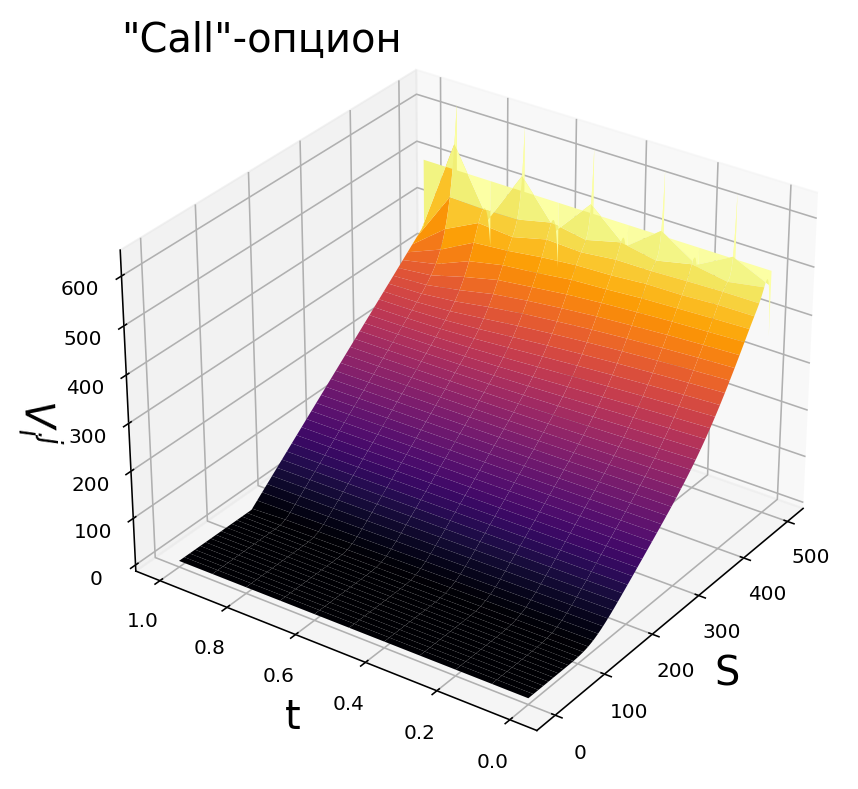

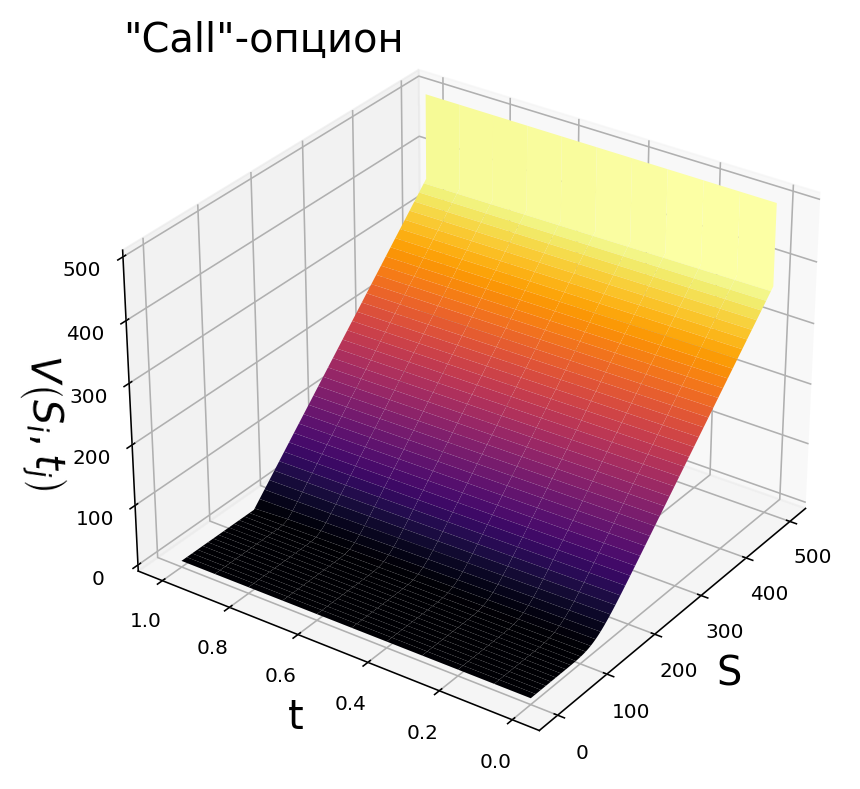

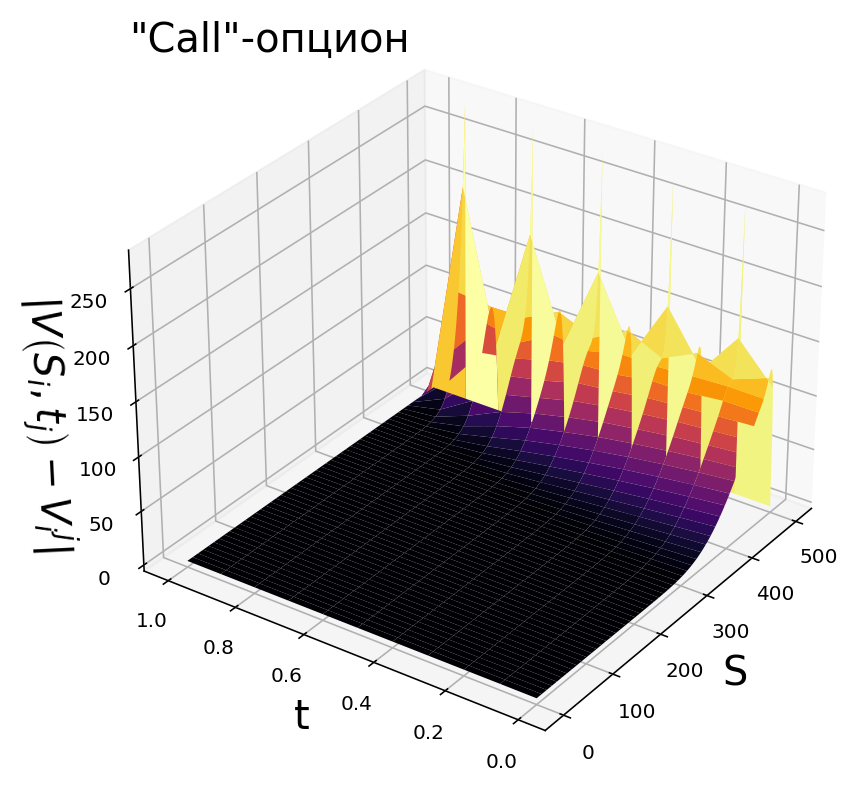

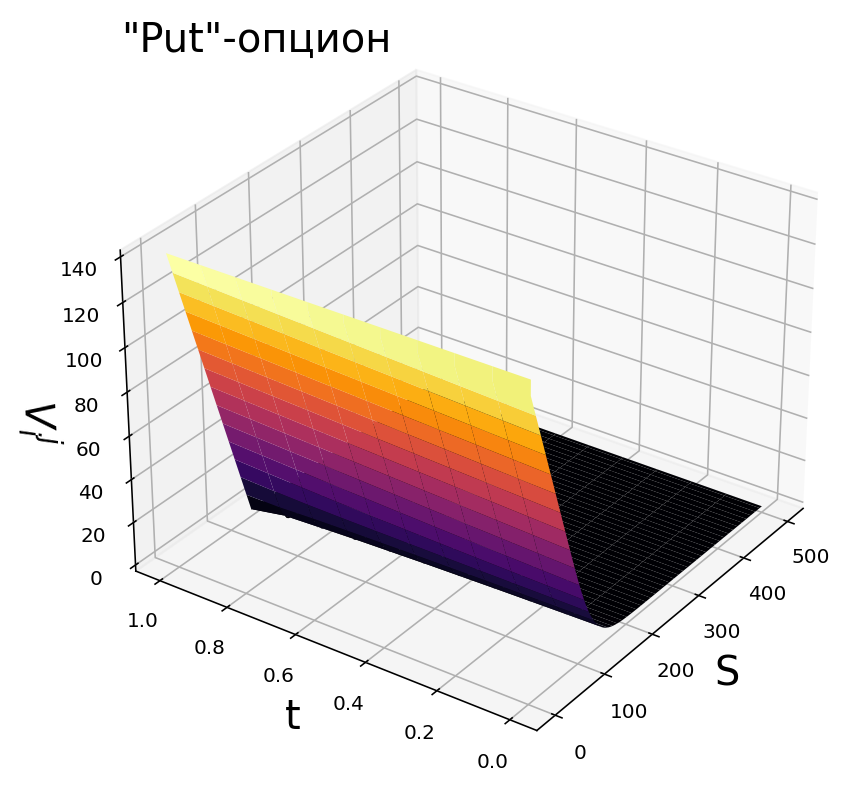

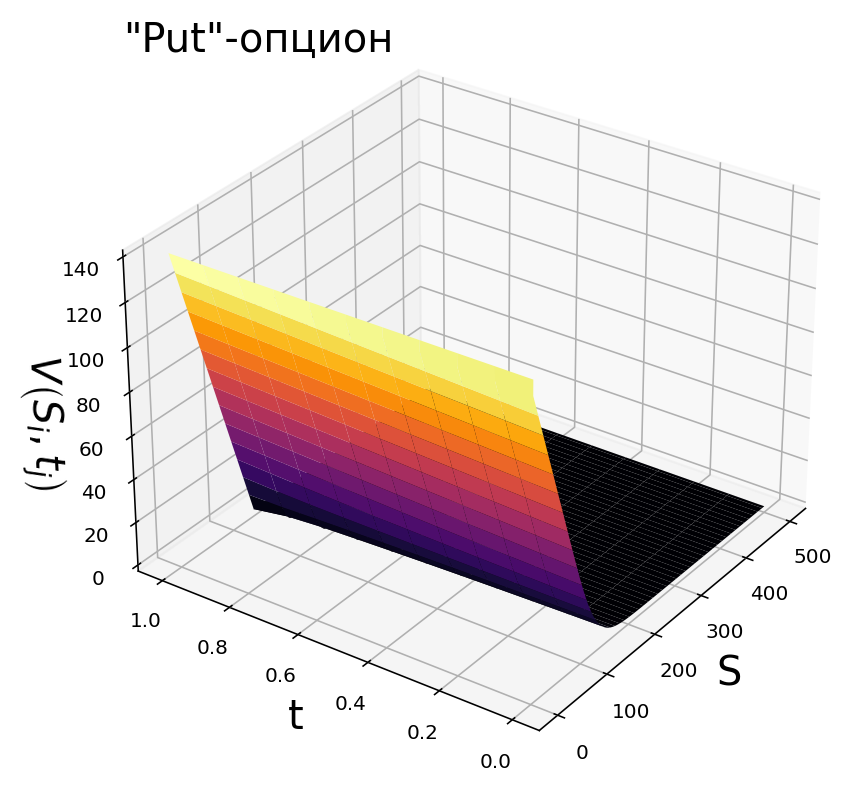

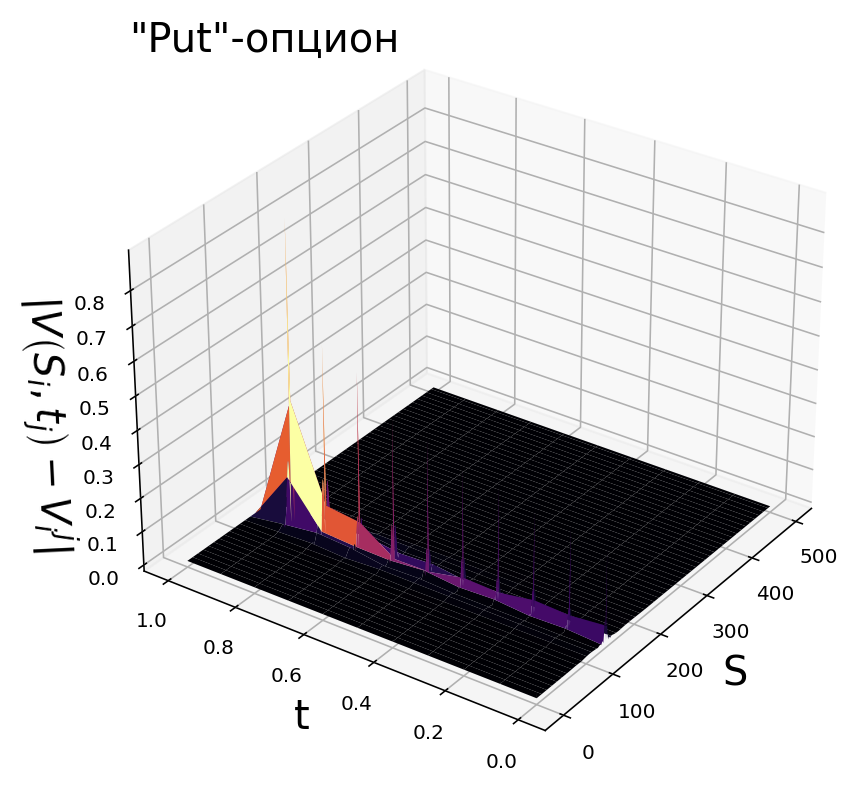

In [4]:
S_max = 500
T = 1
E = 140
r = 0.05
sigma = 0.2
tau = h = 1e-1

analyze(S_max, T, E, r, sigma, tau, h, 'Call')
analyze(S_max, T, E, r, sigma, tau, h, 'Put')